In [51]:
from typing import List, Tuple, Iterable
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import scipy
import qiskit
from qiskit.quantum_info import SparsePauliOp
import math
from typing import *
import random
import itertools
from functools import reduce
from collections import Counter

In [61]:
class discriminativeQRBM():

    """
    A bound-based restricted quantum Boltzmann Machine based on "Quantum Boltzmann Machine" 
    by Amin et al. for discriminative learning tasks
    """

    def __init__(self, **kwargs) -> None:
        """
        Initialize the RBM model with various parameters.

        Parameters
        ----------
        numOutput: int, required
            The number of output nodes in the visible layer.
        numHidden: int, required
            The number of hidden nodes in the hidden layer. 
        numInput: int, required
            The number of input nodes.
        beta: float, optional
            Specifies the inverse of the temperature. Default is 100.
        qrbm: bool, optional
            Set to True to add transverse (gamma) terms to Hamiltonian. Default is False.
        """
        if not kwargs.get('numOutput'):
            raise Exception('You must specify the number of output variables for the RBM.')
        else:
            numOutput = kwargs.get('numOutput')
            self.num_output_vars = numOutput

        if not kwargs.get('numHidden'):
            raise Exception('You must specify the number of hidden variables for the RBM.')
        else:
            numHidden = kwargs.get('numHidden')
            self.num_hidden_vars = numHidden

        if not kwargs.get('numInput'):
            raise Exception('You must specify the number of input variables for the RBM.')
        else:
            numInput = kwargs.get('numInput')
            self.num_input_vars = numInput

        self.matrixMap = {'X': np.array([[0, 1], [1, 0]], dtype=complex),
                          'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
                          'Z': np.array([[1, 0], [0, -1]], dtype=complex),
                          'I': np.identity(2)}

        self.beta = kwargs.get('beta', 100)
        self.qrbm = kwargs.get('qrbm', False)

        self.output_vars = [i for i in range(numOutput)] # start here
        self.hidden_vars = [i for i in range(numOutput, numOutput + numHidden)] # continue where output left off
        self.input_vars = [i for i in range(numOutput + numHidden, numOutput + numHidden + numInput)] # continue where hidden left off


        self.a_vars = self.output_vars + self.hidden_vars
        self.a_num = len(self.a_vars)

        self.ab_edges = [] # (output, hidden)

        for output in self.output_vars:
            for hidden in self.hidden_vars:
                self.ab_edges.append((output, hidden))

        self.aµ_edges = [] # (hidden/output, input)

        for inpt in self.input_vars:
            for a in self.a_vars: # iterate over hidden and output 
                self.aµ_edges.append((a, inpt))


        self.num_ab_edges = len(self.ab_edges)
        self.num_aµ_edges = len(self.aµ_edges)

            
        # np.random.seed(42)
        self.b_a_values = {a: np.random.normal(loc=0, scale=.01) for a in self.a_vars}
        self.Γ_a_values = {a: np.random.normal(loc=0, scale=.01) for a in self.a_vars}
        # self.Γ_a_values = {a: 2 for a in self.a_vars}
        self.w_ab_values = {ab: np.random.normal(loc=0, scale=.01) for ab in self.ab_edges}
        self.w_aμ_values = {aµ: np.random.normal(loc=0, scale=.01) for aµ in self.aµ_edges}

        # self.b_a_values = {a: np.random.normal(loc=0, scale=.0001) for a in self.a_vars}
        # self.Γ_a_values = {a: np.random.normal(loc=0, scale=.0001) for a in self.a_vars}
        # self.w_ab_values = {ab: np.random.normal(loc=0, scale=.0001) for ab in self.ab_edges}
        # self.w_aμ_values = {aµ: np.random.normal(loc=0, scale=.0001) for aµ in self.aµ_edges}

        print('self.output_vars', self.output_vars)
        print('self.hidden_vars', self.hidden_vars)
        print('self.input_vars', self.input_vars)
        print('self.a_vars', self.a_vars)
        

        print('self.b_a_values', self.b_a_values)
        print('self.Γ_a_values', self.Γ_a_values)
        print('self.w_ab_values', self.w_ab_values)
        print('self.w_aμ_values', self.w_aμ_values)
        print()


    def PxData(self, data: List[Tuple[Tuple[int], Tuple[int]]]) -> Dict[Tuple[int], float]:
    
        inputs = []
        for d in data:
            inpt, _ = d
            if len(inpt) != self.num_input_vars:
                raise Exception('Input does not match the size of the network.')
            inputs.append(inpt)
    
        sampleSpaceSize = len(inputs) # (assuming binary values)
        count_dict = dict(Counter(inputs))
    
        return {key: val/sampleSpaceSize for key, val in count_dict.items()}
    
    
    def PxyData(self, data: List[Tuple[Tuple[int], Tuple[int]]]) -> Dict[Tuple[Tuple[int], Tuple[int]], float]:
    
        for d in data:
            inpt, output = d
            if len(inpt) != self.num_input_vars or len(output) != self.num_output_vars:
                raise Exception('Input or output does not match size of the network.')
    
        sampleSpaceSize = len(data)
        count_dict = dict(Counter(data))
    
        return {key: val/sampleSpaceSize for key, val in count_dict.items()}


    def llh(self, PxyData) -> float:
        
        total = 0

        for xy in PxyData:
            x, _ = xy
            numerator = np.trace(scipy.linalg.expm(-self.Hx(x) * self.beta))
            denominator = np.trace(scipy.linalg.expm(-self.Hxy(xy) * self.beta))

            total += PxyData[xy] * np.log(numerator / denominator) # += should really be -= (+= makes graph more readable)

        return total


    def train(self, **kwargs) -> None:
        """
        Train the RBM.

        Parameters
        ----------
        data: List ((input, output), ... ), required
            Training data where input and output are each tuples themselves
        epochs: int, optional
            Specify the number of epochs to train. Default is 200.
        learningRate: float, optional
            Specify the learning rate. Default is .001
        optimizer: str in ["adam", ], optional
            Specify an optimizer. Default is "adam".
        alpha: float, optional
            Specify the learning rate / alpha hyperparamter for Adam. Default is .001.
        b1 : float, optional
            Exponential decay rate for the first moment estimates (beta1) for ADAM optimizer. Default is 0.9.
        b2 : float, optional
            Exponential decay rate for the second moment estimates (beta2) for ADAM optimizer. Default is 0.999.
        epsilon : float, optional
            Small constant for numerical stability in ADAM optimizer. Default is 1e-8.
        """
        if not kwargs.get('data'):
            raise Exception('Must pass in training data.')
        else:
            data = kwargs.get('data')
        epochs = kwargs.get('epochs', 200)
        learningRate = kwargs.get('alpha', .001)

        optimizer = kwargs.get('optimizer', None)
        optimizer = optimizer.lower() if optimizer else optimizer
        
        alpha = kwargs.get('alpha', .001)
        b1 = kwargs.get('b1', .9)
        b2 = kwargs.get('b2', .999)
        epsilon = kwargs.get('epsilon', 1e-8)

        PxyData = self.PxyData(data)
        PxData = self.PxData(data)

        track_b_a = []
        track_w_ab = []
        track_w_aµ = []
        track_Γ_a = []
        track_llh = []

        m_b_a = {a: 0 for a in self.b_a_values}
        v_b_a = {a: 0 for a in self.b_a_values}

        m_w_ab = {ab: 0 for ab in self.w_ab_values}
        v_w_ab = {ab: 0 for ab in self.w_ab_values}

        m_w_aµ = {aµ: 0 for aµ in self.w_aµ_values}
        v_w_aµ = {aµ: 0 for aµ in self.w_aµ_values}

        m_Γ_a = {a: 0 for a in self.Γ_a_values}
        v_Γ_a = {a: 0 for a in self.Γ_a_values}

        for epoch in range(epochs):

            new_b_a_values = copy.copy(self.b_a_values)
            new_w_ab_values = copy.copy(self.w_ab_values)
            new_w_aµ_values = copy.copy(self.w_aµ_values)
            new_Γ_a_values = copy.copy(self.Γ_a_values)

            xytoHxy = {xy: self.Hxy(xy) for xy in PxyData}
            xtoHx =  {x: self.Hx(x) for x in PxData}
                
    
            #############################################################################################################
    
            # b_a_values
            
            g_b_a = {a: 0 for a in self.b_a_values}
            for a in self.b_a_values:
                positivePhase = self.positive_b_a(a, PxyData, xytoHxy)
                negativePhase = self.negative_b_a(a, PxData, xtoHx)
                gradientStep = positivePhase - negativePhase
                g_b_a[a] = gradientStep

            if not optimizer:
                for a in self.b_a_values:
                    new_b_a_values[a] += learningRate * g_b_a[a]

            elif optimizer == 'adam':

                m_b_a = {a: b1 * m_b_a[a] + (1 - b1) * g_b_a[a] for a in self.b_a_values}
                v_b_a = {a: b2 * v_b_a[a] + (1 - b2) * (g_b_a[a] ** 2) for a in self.b_a_values}

                mHat_b_a = {a: m_b_a[a] / (1 - (b1 ** (epoch + 1))) for a in self.b_a_values}
                vHat_b_a = {a: v_b_a[a] / (1 - (b2 ** (epoch + 1))) for a in self.b_a_values}

                adamTerm = {a: -1 * alpha * mHat_b_a[a] / (math.sqrt(vHat_b_a[a]) + epsilon) for a in self.b_a_values}

                for a in self.b_a_values:
                    new_b_a_values[a] -= adamTerm[a]

        
            #############################################################################################################
    
            # w_ab_values

            g_w_ab = {ab: 0 for ab in self.w_ab_values}
            for ab in self.w_ab_values:
                a, b = ab
                positivePhase = self.positive_w_ab(a, b, PxyData, xytoHxy)
                negativePhase = self.negative_w_ab(a, b, PxData, xtoHx)
                gradientStep = positivePhase - negativePhase
                g_w_ab[ab] = gradientStep
                    
            if not optimizer:
                for ab in self.w_ab_values:
                    new_w_ab_values[ab] += learningRate * g_w_ab[ab]

            elif optimizer == 'adam':

                m_w_ab = {ab: b1 * m_w_ab[ab] + (1 - b1) * g_w_ab[ab] for ab in self.w_ab_values}
                v_w_ab = {ab: b2 * v_w_ab[ab] + (1 - b2) * (g_w_ab[ab] ** 2) for ab in self.w_ab_values}

                mHat_w_ab = {ab: m_w_ab[ab] / (1 - (b1 ** (epoch + 1))) for ab in self.w_ab_values}
                vHat_w_ab = {ab: v_w_ab[ab] / (1 - (b2 ** (epoch + 1))) for ab in self.w_ab_values}

                adamTerm = {ab: -1 * alpha * mHat_w_ab[ab] / (math.sqrt(vHat_w_ab[ab]) + epsilon) for ab in self.w_ab_values}

                for ab in self.w_ab_values:
                    new_w_ab_values[ab] -= adamTerm[ab]
    
            #############################################################################################################
    
            # w_aµ_values
            
            g_w_aµ = {aµ: 0 for aµ in self.w_aµ_values}
            for aµ, _ in self.w_aµ_values.items():
                a, shifted_µ = aµ
                µ = shifted_µ - self.a_num
                positivePhase = self.positive_w_aµ(a, µ, PxyData, xytoHxy)
                negativePhase = self.negative_w_aµ(a, µ, PxData, xtoHx)
                gradientStep = positivePhase - negativePhase
                g_w_aµ[aµ] = gradientStep
                
            if not optimizer:
                for aµ in self.w_aµ_values:
                    new_w_aµ_values[aµ] += learningRate * g_w_aµ[aµ]

            elif optimizer == 'adam':

                m_w_aµ = {aµ: b1 * m_w_aµ[aµ] + (1 - b1) * g_w_aµ[aµ] for aµ in self.w_aµ_values}
                v_w_aµ = {aµ: b2 * v_w_aµ[aµ] + (1 - b2) * (g_w_aµ[aµ] ** 2) for aµ in self.w_aµ_values}

                mHat_w_aµ = {aµ: m_w_aµ[aµ] / (1 - (b1 ** (epoch + 1))) for aµ in self.w_aµ_values}
                vHat_w_aµ = {aµ: v_w_aµ[aµ] / (1 - (b2 ** (epoch + 1))) for aµ in self.w_aµ_values}

                adamTerm = {aµ: -1 * alpha * mHat_w_aµ[aµ] / (math.sqrt(vHat_w_aµ[aµ]) + epsilon) for aµ in self.w_aµ_values}

                for aµ in self.w_aµ_values:
                    new_w_aµ_values[aµ] -= adamTerm[aµ]
    
            #############################################################################################################

            # Γ_a_values
                
            g_Γ_a = {a: 0 for a in self.Γ_a_values}
            for a in self.Γ_a_values:
                positivePhase = self.positive_Γ_a(a, PxyData, xytoHxy)
                negativePhase = self.negative_Γ_a(a, PxData, xtoHx)
                gradientStep = positivePhase - negativePhase
                g_Γ_a[a] = gradientStep

            if not optimizer:
                for a in self.Γ_a_values:
                    new_Γ_a_values[a] += learningRate * g_Γ_a[a]

            elif optimizer == 'adam':
                m_Γ_a = {a: b1 * m_Γ_a[a] + (1 - b1) * g_Γ_a[a] for a in self.Γ_a_values}
                v_Γ_a = {a: b2 * v_Γ_a[a] + (1 - b2) * (g_Γ_a[a] ** 2) for a in self.Γ_a_values}

                mHat_Γ_a = {a: m_Γ_a[a] / (1 - (b1 ** (epoch + 1))) for a in self.Γ_a_values}
                vHat_Γ_a = {a: v_Γ_a[a] / (1 - (b2 ** (epoch + 1))) for a in self.Γ_a_values}

                adamTerm = {a: -1 * alpha * mHat_Γ_a[a] / (math.sqrt(vHat_Γ_a[a]) + epsilon) for a in self.Γ_a_values}
            
                for a in self.Γ_a_values:
                    new_Γ_a_values[a] -= adamTerm[a]
            
            #############################################################################################################

            track_b_a.append((epoch, new_b_a_values))
            track_w_ab.append((epoch, new_w_ab_values))
            track_w_aµ.append((epoch, new_w_aµ_values))
            track_Γ_a.append((epoch, new_Γ_a_values))
            track_llh.append((epoch, self.llh(PxyData)))
            
            self.b_a_values = new_b_a_values
            self.w_ab_values = new_w_ab_values
            self.w_aµ_values = new_w_aµ_values
            self.Γ_a_values = new_Γ_a_values
            

        # print(track_llh)
        self.plotAbsoluteWeights(track_b_a, track_w_ab, track_w_aµ, track_Γ_a)
        self.graphLLH(track_llh)


    def get_sigma_matrix(self, sigma: str, constant: int) -> np.ndarray:
        
        matrixList = [self.matrixMap[letter] for letter in sigma]
        return np.real(reduce(np.kron, matrixList) * constant)


    def b_a_eff(self, a: int, x: List[int]) -> int:
        
        total = self.b_a_values[a]
        
        for µ, x_µ in enumerate(x, start=self.input_vars[0]):
                        
            total += self.w_aµ_values[(a, µ)] * x_µ

        return total


    def getYbra_ket(self, y: List[int]) -> np.matrix: 
        stateIndex = -1
        for i, node in enumerate(reversed(y)):
            if node == 1:
                stateIndex -= int(math.pow(2, i))
        bra = [0] * int(math.pow(2, len(self.output_vars)))
        bra[stateIndex] = 1
        bra = np.matrix(bra).reshape(1, -1)
        ket = bra.H

        return (bra, ket)


    def P_y_given_x(self, y: List[int], x: List[int]) -> float:

        bra, ket = self.getYbra_ket(y)
        outerProd = ket @ bra  

        Ix = np.identity(int(math.pow(2, len(self.input_vars))))
        Ih = np.identity(int(math.pow(2, len(self.hidden_vars))))

        lambdaY = np.kron(outerProd, Ih)

        Hx = self.Hx(x)
        eToNegHx = scipy.linalg.expm(-Hx * self.beta)
        numerator = np.trace(lambdaY @ eToNegHx)
        denominator = np.trace(eToNegHx)

        # print('p')
        # print(eToNegHx / denominator)
        # print('lambdaY')
        # print(lambdaY)
        
        return numerator / denominator


    def Hx(self, x: List[int]) -> np.ndarray:

        terms = []

        for a in self.a_vars:
            sigmaZ = ['I'] * self.a_num
            sigmaZ[a] = 'Z'
            terms.append(self.get_sigma_matrix(sigmaZ, -1 * self.b_a_eff(a, x)))

        if self.qrbm:
            for a in self.a_vars:
                sigmaX = ['I'] * self.a_num
                sigmaX[a] = 'X'
                terms.append(self.get_sigma_matrix(sigmaX, -1 * self.Γ_a_values[a]))

        for ab_edge in self.ab_edges:
            n1, n2 = ab_edge
            doubleSigmaZ = ['I'] * self.a_num
            doubleSigmaZ[n1] = 'Z'
            doubleSigmaZ[n2] = 'Z'
            terms.append(self.get_sigma_matrix(doubleSigmaZ, -1 * self.w_ab_values[ab_edge]))
        
        return np.sum(terms, axis=0)


    def Hxy(self, xy: Tuple[List[int], List[int]]) -> np.ndarray:

        x, y = xy
        terms = []

        for a in self.a_vars:
            sigmaZ = ['I'] * self.a_num
            c = 1
            if a in self.output_vars:
                c *= y[a]
            else:
                sigmaZ[a] = 'Z'
            terms.append(self.get_sigma_matrix(sigmaZ, -1 * c * self.b_a_eff(a, x)))

        if self.qrbm:
            for a in self.a_vars:
                if a in self.output_vars: # Expectation will always be zero
                    continue
                sigmaX = ['I'] * self.a_num
                sigmaX[a] = 'X'
                terms.append(self.get_sigma_matrix(sigmaX, -1 * self.Γ_a_values[a]))

        for ab_edge in self.ab_edges:
            n1, n2 = ab_edge
            doubleSigmaZ = ['I'] * self.a_num

            c = 1
            if n1 in self.output_vars and n2 in self.output_vars:
                raise Exception("Output-output weight detected. Probably can't have this.")
            elif n1 in self.output_vars:
                c *= y[n1]
                doubleSigmaZ[n2] = 'Z'
            elif n2 in self.output_vars:
                c *= y[n2]
                doubleSigmaZ[n1] = 'Z'
                
            terms.append(self.get_sigma_matrix(doubleSigmaZ, -1 * c * self.w_ab_values[ab_edge]))

        
        return np.sum(terms, axis=0)


    def expectation(self, H: np.ndarray, A: np.ndarray) -> float:

        eToNegH = scipy.linalg.expm(-H * self.beta)
        numerator = np.trace(eToNegH @ A)
        denominator = np.trace(eToNegH)

        return numerator / denominator


    def positive_b_a(self, a: int, PxyData: Dict[Tuple[Tuple[int], Tuple[int]], float], xytoHxy: Dict[Tuple[Tuple[int], Tuple[int]], np.ndarray]) -> float:
    
        total = 0

        for xy, p in PxyData.items():

            _, y = xy
        
            A = ['I'] * self.a_num
            c = 1
            if a in self.output_vars:
                c *= y[a]
            else:
                A[a] = 'Z'
                
            A = self.get_sigma_matrix(A, c)

            total += p * self.expectation(xytoHxy[xy], A)

        return total


    def negative_b_a(self, a: int, PxData: Dict[Tuple[int], float], xtoHx: Dict[Tuple[int], np.ndarray]) -> float:

        A = ['I'] * self.a_num
        A[a] = 'Z'
        A = self.get_sigma_matrix(A, 1)
            
        total = 0

        for x, p in PxData.items():

                total += p * self.expectation(xtoHx[x], A)

        return total


    def positive_w_ab(self, a: int, b: int, PxyData: Dict[Tuple[Tuple[int], Tuple[int]], float], xytoHxy: Dict[Tuple[Tuple[int], Tuple[int]], np.ndarray]) -> float:

        total = 0

        for xy, p in PxyData.items():

            _, y = xy

            A = ['I'] * self.a_num
            c = 1
            if a in self.output_vars:
                c *= y[a]
            else:
                A[a] = 'Z'
            if b in self.output_vars:
                c *= y[b]
            else:
                A[b] = 'Z'
            A = self.get_sigma_matrix(A, c)

            total += p * self.expectation(xytoHxy[xy], A)

        return total


    def negative_w_ab(self, a: int, b: int, PxData: Dict[Tuple[int], float], xtoHx: Dict[Tuple[int], np.ndarray]) -> float:

        A = ['I'] * self.a_num
        A[a] = 'Z'
        A[b] = 'Z'
        A = self.get_sigma_matrix(A, 1)

        total = 0

        for x, p in PxData.items():

            total += p * self.expectation(xtoHx[x], A)

        return total


    def positive_w_aµ(self, a: int, µ: int, PxyData: Dict[Tuple[Tuple[int], Tuple[int]], float], xytoHxy: Dict[Tuple[Tuple[int], Tuple[int]], np.ndarray]) -> float:

        total = 0

        for xy, p in PxyData.items():

            x, y = xy
        
            A = ['I'] * self.a_num
            c = 1
            if a in self.output_vars:
                c *= y[a]
            else:
                A[a] = 'Z'
            A = self.get_sigma_matrix(A, x[µ] * c)
    
            total += p * self.expectation(xytoHxy[xy], A)

        return total


    def negative_w_aµ(self, a: int, µ: int, PxData: Dict[Tuple[int], float], xtoHx: Dict[Tuple[int], np.ndarray]) -> float:

        total = 0

        for x, p in PxData.items():

            A = ['I'] * self.a_num
            A[a] = 'Z'
            A = self.get_sigma_matrix(A, x[µ])
            
            total += p * self.expectation(xtoHx[x], A)

        return total


    def positive_Γ_a(self, a: int, PxyData: Dict[Tuple[Tuple[int], Tuple[int]], float], xytoHxy: Dict[Tuple[Tuple[int], Tuple[int]], np.ndarray]) -> float:
    
        total = 0

        for xy, p in PxyData.items():

            _, y = xy
        
            A = ['I'] * self.a_num
            c = 1
            if a in self.output_vars:
                c *= 0
            else:
                A[a] = 'X'
                
            A = self.get_sigma_matrix(A, c)

            total += p * self.expectation(xytoHxy[xy], A)

        return total


    def negative_Γ_a(self, a: int, PxData: Dict[Tuple[int], float], xtoHx: Dict[Tuple[int], np.ndarray]) -> float:

        A = ['I'] * self.a_num
        A[a] = 'X'
        A = self.get_sigma_matrix(A, 1)

        total = 0

        for x, p in PxData.items():

                total += p * self.expectation(xtoHx[x], A)

        return total


    def plotAbsoluteWeights(self, 
                            track_b_a: List[Tuple[int, Dict[int, float]]],
                            track_w_ab: List[Tuple[int, Dict[Tuple[int, int], float]]],
                            track_w_aµ: List[Tuple[int, Dict[Tuple[int, int], float]]], 
                            track_Γ_a: List[Tuple[int, Dict[Tuple[int, int], float]]]) -> None:
        """
        Plots the absolute values of each weight in a different color on one graph.
        """
        plt.figure(figsize=(12, 8))

        # Plot absolute biases for b_a
        epochs_b_a, b_a_values = zip(*track_b_a)
        for a in self.a_vars:
            b_biases = [abs(b_a[a]) for _, b_a in track_b_a]
            plt.plot(epochs_b_a, b_biases, marker='o', linestyle='-', label=f'Bias b_{a}')

        # Plot absolute weights for ab_edges
        epochs_w_ab, w_ab_values = zip(*track_w_ab)
        for ab in self.ab_edges:
            ab_weights = [abs(w_ab[ab]) for _, w_ab in track_w_ab]
            plt.plot(epochs_w_ab, ab_weights, marker='x', linestyle='--', label=f'Weight w_ab {ab}')

        # Plot absolute weights for aµ_edges
        epochs_w_aµ, w_aµ_values = zip(*track_w_aµ)
        for aµ in self.aµ_edges:
            aµ_weights = [abs(w_aµ[aµ]) for _, w_aµ in track_w_aµ]
            plt.plot(epochs_w_aµ, aµ_weights, marker='s', linestyle='-.', label=f'Weight w_aµ {aµ}')

        # Plot absolute biases for Γ_a
        epochs_Γ_a, Γ_a_values = zip(*track_Γ_a)
        for a in self.a_vars:
            Γ_biases = [abs(Γ_a[a]) for _, Γ_a in track_Γ_a]
            plt.plot(epochs_Γ_a, Γ_biases, marker='o', linestyle='-', label=f'Bias Γ_{a}')

        plt.xlabel('Epoch')
        plt.ylabel('Weight/bias val')
        plt.title('Absolute Value of Weights and Biases by Epoch')
        plt.legend()
        plt.grid(True)
        plt.show()


    def graphLLH(self, track_llh: List[Tuple[int, float]]) -> None:
        """
        Plots log-likelihood by epoch.
        """
        epochs, logLikelihoods = zip(*track_llh)
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, logLikelihoods, marker='o', linestyle='-')
        plt.xlabel('Epoch')
        plt.ylabel('Log-Likelihood')
        plt.title('Log-Likelihood by Epoch')
        plt.grid(True)
        plt.show()

self.output_vars [0]
self.hidden_vars [1]
self.input_vars [2, 3, 4, 5]
self.a_vars [0, 1]
self.b_a_values {0: 0.013084316717516387, 1: -0.020330829752462802}
self.Γ_a_values {0: 0.008057993463500323, 1: 0.010801945060459341}
self.w_ab_values {(0, 1): -0.018338713606629527}
self.w_aμ_values {(0, 2): -0.004487733766201857, (1, 2): -0.0007088373595753471, (0, 3): -0.0062872924675395694, (1, 3): -0.002300550348307956, (0, 4): 0.005008447499820728, (1, 4): -0.0019944830780287428, (0, 5): -0.01717570689048633, (1, 5): 0.011280434317237947}



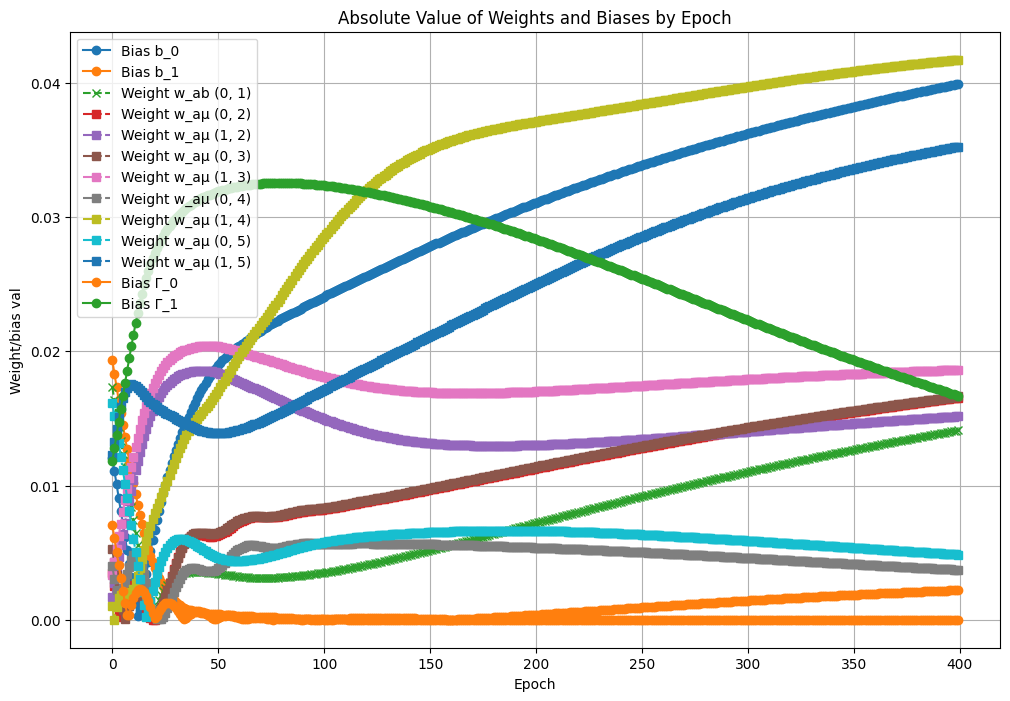

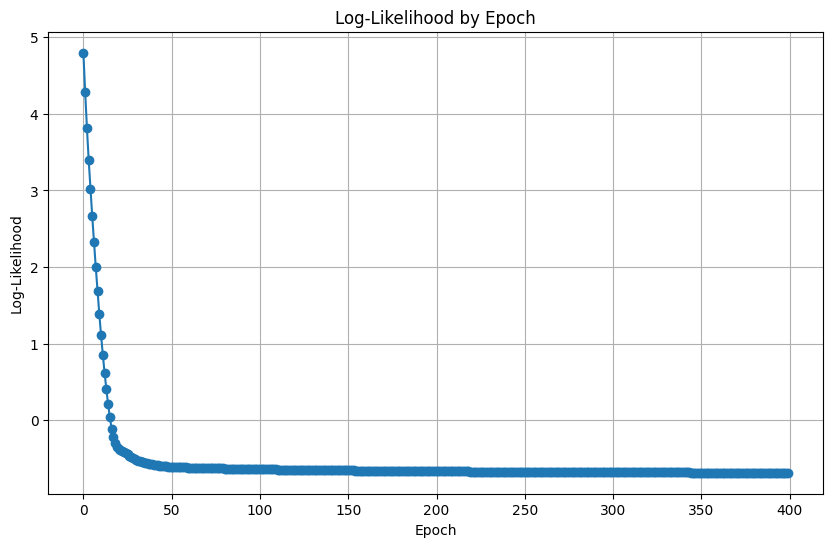

(1,) given (1, 1, 1, 1): 0.9508353565244972
(1,) given (-1, -1, -1, -1): 5.747848283055639e-09
(1,) given (-1, -1, -1, 1): 5.279808493388201e-06
(1,) given (-1, -1, 1, -1): 4.567338145733868e-06
(1,) given (-1, -1, 1, 1): 4.0291306336256564e-05
(1,) given (-1, 1, -1, -1): 3.91649035127921e-06
(1,) given (-1, 1, -1, 1): 0.00010730140549398455
(1,) given (-1, 1, 1, -1): 0.00030481022280262393
(1,) given (-1, 1, 1, 1): 0.029092721688834335
(1,) given (1, -1, -1, -1): 3.83598985613925e-06
(1,) given (1, -1, -1, 1): 0.00022039184266124185
(1,) given (1, -1, 1, -1): 0.0006813535578539232
(1,) given (1, -1, 1, 1): 0.028568570166229212
(1,) given (1, 1, -1, -1): 0.0028620706465403195
(1,) given (1, 1, -1, 1): 0.023536556203931327
(1,) given (1, 1, 1, -1): 0.018652332430470733


In [67]:
data = [((1,), (1,)), ((-1,), (-1,))]

data = [((1,1,1,1), (1,)), 
        ((-1,-1,-1,-1), (-1,)), 
        ((-1,-1,-1,1), (-1,)), 
        ((-1,-1,1,-1), (-1,)),
        ((-1,-1,1,1), (-1,)),
        ((-1,1,-1,-1), (-1,)),
        ((-1,1,-1,1), (-1,)),
        ((-1,1,1,-1), (-1,)),
        ((-1,1,1,1), (-1,)),
        ((1,-1,-1,-1), (-1,)),
        ((1,-1,-1,1), (-1,)),
        ((1,-1,1,-1), (-1,)),
        ((1,-1,1,1), (-1,)),
        ((1,1,-1,-1), (-1,)),
        ((1,1,-1,1), (-1,)),
        ((1,1,1,-1), (-1,))]

rbm = discriminativeQRBM(numOutput=1, numHidden=1, numInput=4, qrbm=True)
rbm.train(data=data, learningRate=.001, epochs=400, optimizer='adam')

for d in data:
    x, y = d
    p = rbm.P_y_given_x((1,), x)
    print(f'(1,) given {x}: {p}')

self.output_vars [0]
self.hidden_vars [1]
self.input_vars [2]
self.a_vars [0, 1]
self.b_a_values {0: 0.012784716753737437, 1: 0.00732990672446047}
self.Γ_a_values {0: 0.0003186737101391793, 1: -0.01736781090313816}
self.w_ab_values {(0, 1): 0.005200540907385407}
self.w_aμ_values {(0, 2): 0.0049697332354989975, (1, 2): 0.0162813902852385}



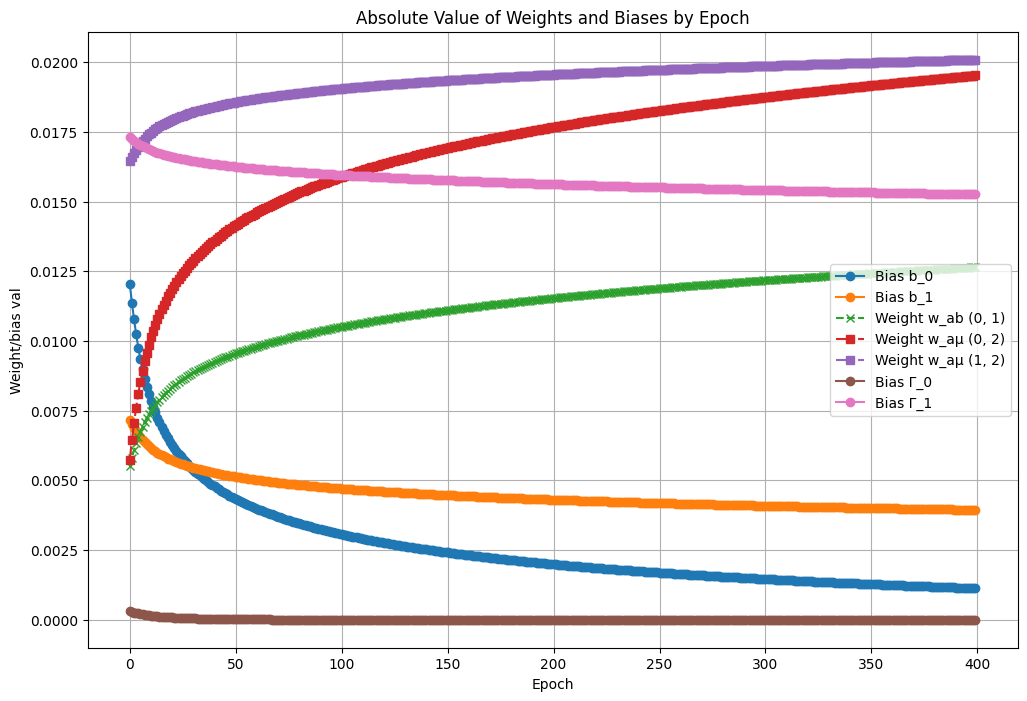

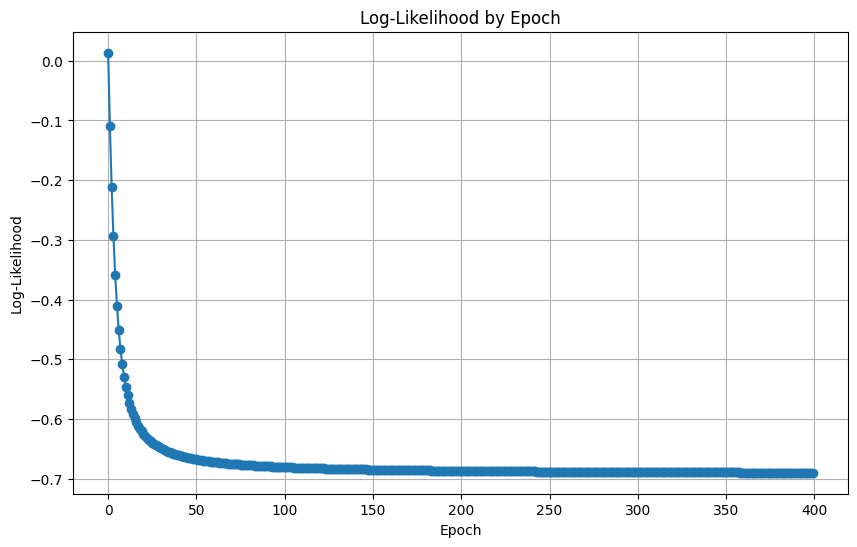

1 given -1 0.00481905366097299
-1 given -1 0.995180946339027
1 given 1 0.997927262244275
-1 given 1 0.0020727377557250844


In [66]:
data = [((1,), (1,)), ((-1,), (-1,))]
rbm = discriminativeQRBM(numOutput=1, numHidden=1, numInput=1, qrbm=True)
PxData = rbm.PxData(data)
PxyData = rbm.PxyData(data)

rbm.train(data=data, learningRate=.001, epochs=400)

print("1 given -1", rbm.P_y_given_x((1,), (-1,)))
print("-1 given -1", rbm.P_y_given_x((-1,), (-1,)))
print("1 given 1", rbm.P_y_given_x((1,), (1,)))
print("-1 given 1", rbm.P_y_given_x((-1,), (1,)))